This document demonstrate how to use the library to define a "density dependent population process" and to compute its mean-field approximation and refined mean-field approximation 

In [1]:
# To load the library
import rmftool as rmf

import importlib
importlib.reload(rmf)

# To plot the results
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Example : The two-choice model

This example illustrate **two ways** of constructing models:
* How to define transitions with a **for loop**  (using the 'eval' function)
* How to use a parameter in the transitions 

The transitions for this model are: 
* $x \mapsto x + \frac1N e_k$ at rate $\rho (x_{k-1}x_{k-1} - x_k x_k)$
* $x \mapsto x - \frac1N e_k$ at rate $\rho (x_k - x_{k+1})$

with the convention : $x_{-1} = 1$ and $x_{K} = 0$ for some $K$. 

In [2]:
# This code creates an object that represents a "density dependent population process"
ddpp = rmf.DDPP()
K = 9 # We use K=9 otherwise the tool is too slow for the 1/N^2 term of transient analysis. 
# If one is only interested in the 1/N term, one can set K=20 or more. 
rho=0.9

# The vector 'e(i)' is a vector where the $i$th coordinate is equal to $1$ (the other being equal to $0$)
def e(i):
    l = np.zeros(K)
    l[i] = 1
    return(l)

# We then add the transitions : 
for i in range(K):
    if i>=1:
        ddpp.add_transition(e(i),eval('lambda x: rho*(x[{}]*x[{}] - x[{}]*x[{}] )'.format(i-1,i-1,i,i) ))
    if i<K-1:
        ddpp.add_transition(-e(i),eval('lambda x: (x[{}] - x[{}])'.format(i,i+1) ))
ddpp.add_transition(e(0), lambda x : rho*(1-x[0]*x[0]))
ddpp.add_transition(-e(K-1), lambda x : x[K-1])



## Simulation and comparison with ODE
We can easily simulate one sample trajectory

### Simulation for various values of $N$

CPU times: user 181 ms, sys: 3.9 ms, total: 184 ms
Wall time: 194 ms
CPU times: user 929 ms, sys: 7.71 ms, total: 937 ms
Wall time: 937 ms


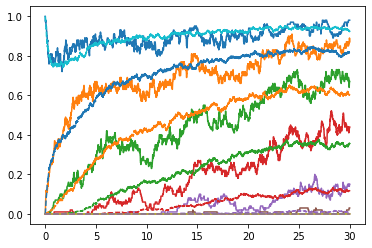

In [3]:
rho = 0.95
ddpp.set_initial_state(e(0)) # We first need to define an initial stater
%time pi,V,W = ddpp.meanFieldExpansionSteadyState(order=1)

T,X = ddpp.simulate(100,time=30) # We first plot a trajectory for $N=100$
plt.plot(T,X)
%time T,X = ddpp.simulate(1000,time=30) # Then for $N=1000$
plt.plot(T,X,'--')

### Comparison with the ODE approximation 
We can easily compare simulations with the ODE approximation

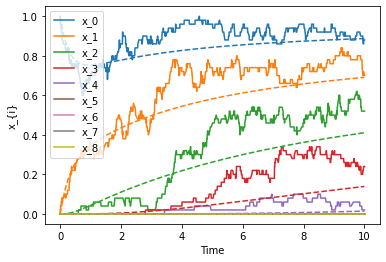

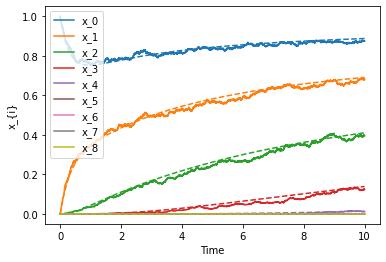

In [4]:
plt.figure()
ddpp.plot_ODE_vs_simulation(N=50)
plt.figure()
ddpp.plot_ODE_vs_simulation(N=1000)

## Refined mean-field approximation
(reference to be added)

This class also contains some functions to compute the fixed point of the mean-field approximation, to compute the "refined mean-field approximation" and to compare it with simulations. 

If $\pi$ is the fixed point of the ODE, and $V$ the constant calculated by the function "meanFieldExpansionSteadyState(order=1)", then we have 

$$E[X^N] = \pi + \frac1N V + o(\frac1N) $$

To compute these constants : 

In [5]:
rho=0.9
pi,V,W = ddpp.meanFieldExpansionSteadyState(order=1)
print(pi,V)

[9.00000000e-01 7.29000000e-01 4.78296900e-01 2.05891132e-01
 3.81520424e-02 1.31002051e-03 1.54453836e-06 2.14703887e-12
 4.14879832e-24] [1.10947416e-16 1.30637870e-01 6.58607162e-01 1.55203165e+00
 1.40535234e+00 2.37444239e-01 2.35232275e-03 1.40482405e-06
 1.93234853e-12]


### Comparison of theoretical V and simulation 

We observe that, for this model, the mean-field approximation is already very close to the simulation. 

**Warning** : for $time=100000/N$, the simulation takes about $10$ sec per value of $N$ but is not that accurate

In [6]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
import misc.jsqD_simulate.average_valueJSQ as jsq

myN = [10,20,30,50,100]
Xs = {}
Vs = {}
Xrmf = {}
for N in myN:
    # For steady-state simulation, 2 options : 
    #  Option 1 : we could use the tool (to do so uncomment the line below)
    #%time Xs[N],Vs[N] = ddpp.steady_state_simulation(N=N,time=100000/N) 
    #  Option 2 : we use simulations from an external tool
    Xs[N],Vs[N] = jsq.loadSteadyStateDistributionQueueLength(N=N,d=2,rho=rho,returnConfInterval=True)
    Xrmf[N] = pi+V/N
    print(N,'done')

make: `simulate_JSQ' is up to date.
10 done
20 done
30 done
50 done
100 done


#### Refined mean-field for the average queue length 
The average queue length is accurately predicted by the refined mean-field 

In [7]:
# Average queue length : 
for N in myN : 
    print(sum(Xs[N]),'+/-',sum(Vs[N]),'(Simulation, N={})'.format(N))
    print(sum(Xrmf[N]),'(refined mean-field, N={})'.format(N))

2.8002988932432435 +/- 0.0008554573286234731 (Simulation, N=10)
2.7512943383090596 (refined mean-field, N=10)
2.5661521090476196 +/- 0.0006952912345058972 (Simulation, N=20)
2.5519729889502796 (refined mean-field, N=20)
2.4917483370634965 +/- 0.0006116985135404344 (Simulation, N=30)
2.4855325391640193 (refined mean-field, N=30)
2.4349531542857137 +/- 0.000561281776808115 (Simulation, N=50)
2.4323801793350106 (refined mean-field, N=50)
2.3930885321739144 +/- 0.0005005628334353826 (Simulation, N=100)
2.3925159094632553 (refined mean-field, N=100)


#### Queue length distribution 

Interestingly, the distribution is not really predicted well for $N=10$ (the refined mean-field over-correct the values around 5).  it seems better for $N\ge30$. 


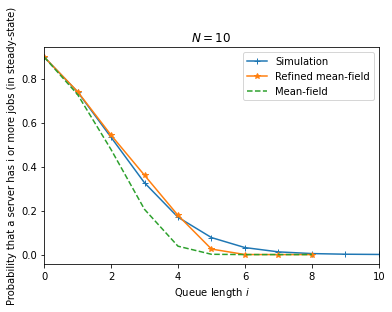

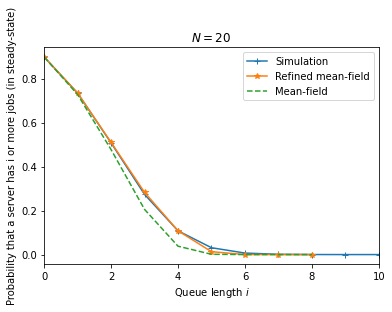

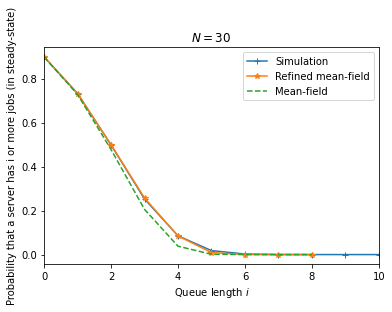

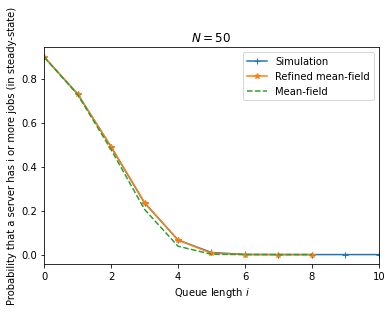

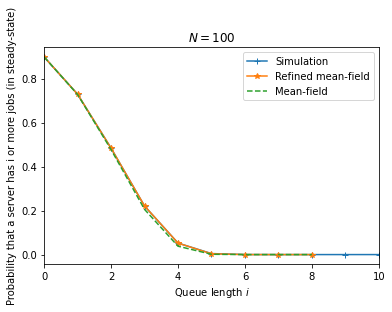

In [8]:
for N in myN:
    plt.figure()
    plt.plot((Xs[N]),'+-')
    plt.plot((Xrmf[N]),'*-')
    plt.plot((pi),'--')
    plt.legend(('Simulation','Refined mean-field','Mean-field'))
    plt.xlabel('Queue length $i$')
    plt.ylabel('Probability that a server has i or more jobs (in steady-state)')
    plt.title('$N={}$'.format(N))
    plt.xlim([0,10])

## $1/N^2$-expansion

### Average queue length

The table below compare the next-order expasion (1/N^2) with the simulation (for steady-state average queue length estimation)

In [9]:
myN = [10,20,30,50,100]
print('        ',end='\t')
for N in myN : print(' N={}  (simu)'.format(N),end='\t')
print()
for rho in [0.7,0.9,0.95]:
    print('rho={}  '.format(rho),end='\t')
    pi,V,A, VWABCD = ddpp.meanFieldExpansionSteadyState(order=2)
    for N in myN:
        print('{0:.4f} ({1:.4f})'.format(sum(pi+V/N+A/N**2),
                                         jsq.loadSteadyStateAverageQueueLength(rho=rho,N=N,d=2)),end='\t')
    print('')


        	 N=10  (simu)	 N=20  (simu)	 N=30  (simu)	 N=50  (simu)	 N=100  (simu)	
rho=0.7  	1.2191 (1.2193)	1.1736 (1.1737)	1.1589 (1.1587)	1.1473 (1.1471)	1.1386 (1.1387)	
rho=0.9  	2.8045 (2.8003)	2.5653 (2.5662)	2.4914 (2.4917)	2.4345 (2.4350)	2.3930 (2.3931)	
rho=0.95  	4.3265 (4.2993)	3.7140 (3.7123)	3.5348 (3.5332)	3.4005 (3.3983)	3.3049 (3.3066)	


### Distribution and $1/N^2$-expansion

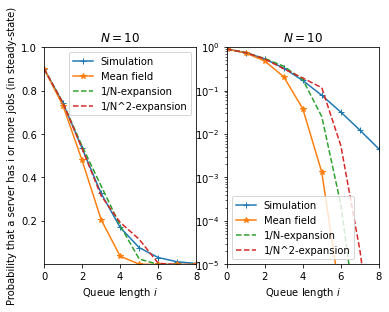

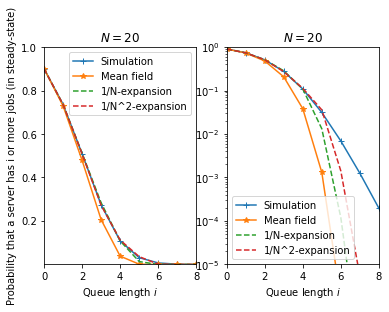

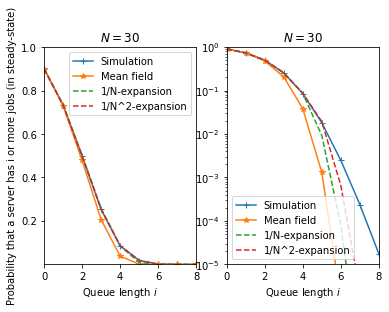

In [10]:
rho=0.9
pi,V,A, VWABCD = ddpp.meanFieldExpansionSteadyState(order=2)
for N in [10,20,30]:
    Xsimu = jsq.loadSteadyStateDistributionQueueLength(N=N,d=2,rho=rho)
    plt.figure()
    for i in [1,2]:
        plt.subplot(1,2,i)
        if i==1: plt.plot((Xsimu),'+-'); plt.ylabel('Probability that a server has i or more jobs (in steady-state)')

        else:    plt.semilogy(Xsimu,'+-')
        plt.plot((pi),'*-')
        plt.plot((pi+V/N),'--')
        plt.plot((pi+V/N+A/N**2),'--')
        plt.legend(('Simulation','Mean field','1/N-expansion','1/N^2-expansion'))
        plt.xlim([0,8])
        plt.ylim([1e-5,1])
        plt.xlabel('Queue length $i$') ;    
        plt.title('$N={}$'.format(N))


## Transient analysis

We plot the average number of jobs as a function of time

In [11]:
x0 = np.zeros(K)
x0[0]=1
x0[1]=1
x0[2]=0.8
rho=0.9
ddpp.set_initial_state(x0)
%time T,X,V,XVW=ddpp.meanFieldExpansionTransient(order=1,time=50)

time to compute drift= 0.15074419975280762
CPU times: user 299 ms, sys: 4.63 ms, total: 304 ms
Wall time: 314 ms


average over  100000 simulations


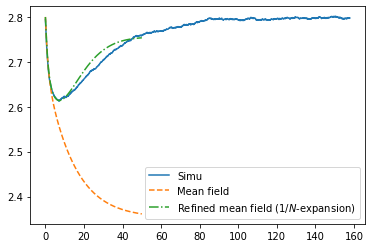

In [12]:
N=10
Tsimu,Xsimu = jsq.loadTransientSimu(rho=0.9,d=2,N=10,initial_number_of_jobs=2.8)
plt.plot(Tsimu,np.sum(Xsimu,1)-1)
plt.plot(T,np.sum(XVW[:,0:K],1),'--')
plt.plot(T,np.sum(XVW[:,0:K]+XVW[:,K:2*K]/N,1),'-.')
plt.legend(('Simu','Mean field','Refined mean field ($1/N$-expansion)'))

## Note on the $1/N^2$-correction term 

Due to symbolic differentiation, it takes too much time to use the tool for the transient analysis of the next order correction $1/N^2$ (at least when the queue size is $K=20$).  For $K=10$, it takes roughly 20 seconds for time=50.  

In [13]:
%time T,X,V,A,XVWABCD=ddpp.meanFieldExpansionTransient(order=2,time=50)
# Warning : can be slow

time to compute drift= 4.501817941665649
CPU times: user 20.6 s, sys: 38.2 s, total: 58.8 s
Wall time: 14.3 s


average over  100000 simulations


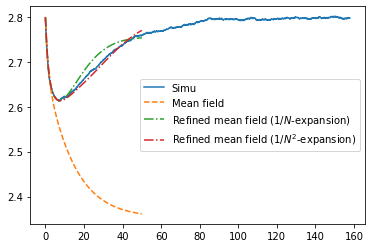

In [14]:
Tsimu,Xsimu = jsq.loadTransientSimu(rho=0.9,d=2,N=10,initial_number_of_jobs=2.8)
plt.plot(Tsimu,np.sum(Xsimu,1)-1)
X = XVWABCD[:,0:K]
V = XVWABCD[:,K:2*K]
A = XVWABCD[:,2*K+K**2:3*K+K**2]
plt.plot(T,np.sum(X,1),'--')
plt.plot(T,np.sum(X+V/N,1),'-.')
plt.plot(T,np.sum(X+V/N+A/N**2,1),'-.')
plt.legend(('Simu','Mean field','Refined mean field ($1/N$-expansion)','Refined mean field ($1/N^2$-expansion)'))